In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
import pystan
from true_params import true_params

/Users/wfarr/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/wfarr/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [18]:
model = pystan.StanModel(file='model_exact.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33be3064fcb5c90df6fdf5c2944874ef NOW.
/Users/wfarr/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpwe5p8iho/stanfit4anon_model_33be3064fcb5c90df6fdf5c2944874ef_3925616943681122279.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [63]:
with h5py.File('observations.h5', 'r') as f:
    nobs, Tobs = f.attrs['1yr']
    nobs = int(round(nobs))
    m1s = array(f['m1s'][:nobs])
    m2s = array(f['m2s'][:nobs])
    zs = array(f['zs'][:nobs])
    dls = Planck15.luminosity_distance(zs).to(u.Gpc).value
    
    m1obs = m1s*(1+zs)
    m2obs = m2s*(1+zs)

In [64]:
nsel = 65536
with h5py.File('selected.h5', 'r') as f:
    N_gen = f.attrs['N_gen']
    m1s_det = array(f['m1det'])
    m2s_det = array(f['m2det'])
    dls_det = array(f['dl'])
    wts_det = array(f['wt'])
    
N = len(m1s_det)
N_gen = int(round(N_gen * nsel / float(N)))
m1s_det = m1s_det[:nsel]
m2s_det = m2s_det[:nsel]
dls_det = dls_det[:nsel]
wts_det = wts_det[:nsel]

In [65]:
ninterp = 512
zinterp = expm1(linspace(log(1), log(11), ninterp))

In [66]:
d = {
    'nobs': nobs,
    'nsel': nsel,
    
    'Tobs': Tobs,
    'N_gen': N_gen,
    
    'm1obs': m1obs,
    'm2obs': m2obs,
    'dlobs': dls,
    
    'm1sel': m1s_det,
    'm2sel': m2s_det,
    'dlsel': dls_det,
    'log_wtsel': log(wts_det),
    
    'ninterp': ninterp,
    'zinterp': zinterp,
    
    'cosmo_prior': 0,
    
    'd_p': Planck15.luminosity_distance(true_params['z_p']).to(u.Gpc).value,
    'z_p': true_params['z_p']
}

In [ ]:
fit = model.sampling(data=d)

In [ ]:
az.plot_trace(fit, var_names=['H0', 'Om', 'w0', 'MMax', 'smooth_max', 'alpha', 'beta', 'gamma', 'neff_det'],
              lines=(('H0', {}, Planck15.H0.to(u.km/u.s/u.Mpc).value),
                     ('Om', {}, Planck15.Om0),
                     ('w0', {}, -1),
                     ('MMax', {}, true_params['MMax']),
                     ('smooth_max', {}, true_params['smooth_max']),
                     ('alpha', {}, true_params['alpha']),
                     ('beta', {}, true_params['beta']),
                     ('gamma', {}, true_params['gamma']),
                     ('neff_det', {}, 5*nobs))) # Ensure we are safe for selection effects

In [ ]:
#fitsmall = fit
#fitsmall_more = fit
#fitsmall_more2 = fit
#fit1yr = fit
fit1yr_more = fit

In [ ]:
az.plot_density([fit1yr, fit1yr_more], var_names=['alpha'], data_labels=['32768', '65536'])

In [9]:
f = az.from_netcdf('exact-4096.nc')
nobs = f.posterior.m1source.values.shape[2]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c19f2c1d0>,
      dtype=object)

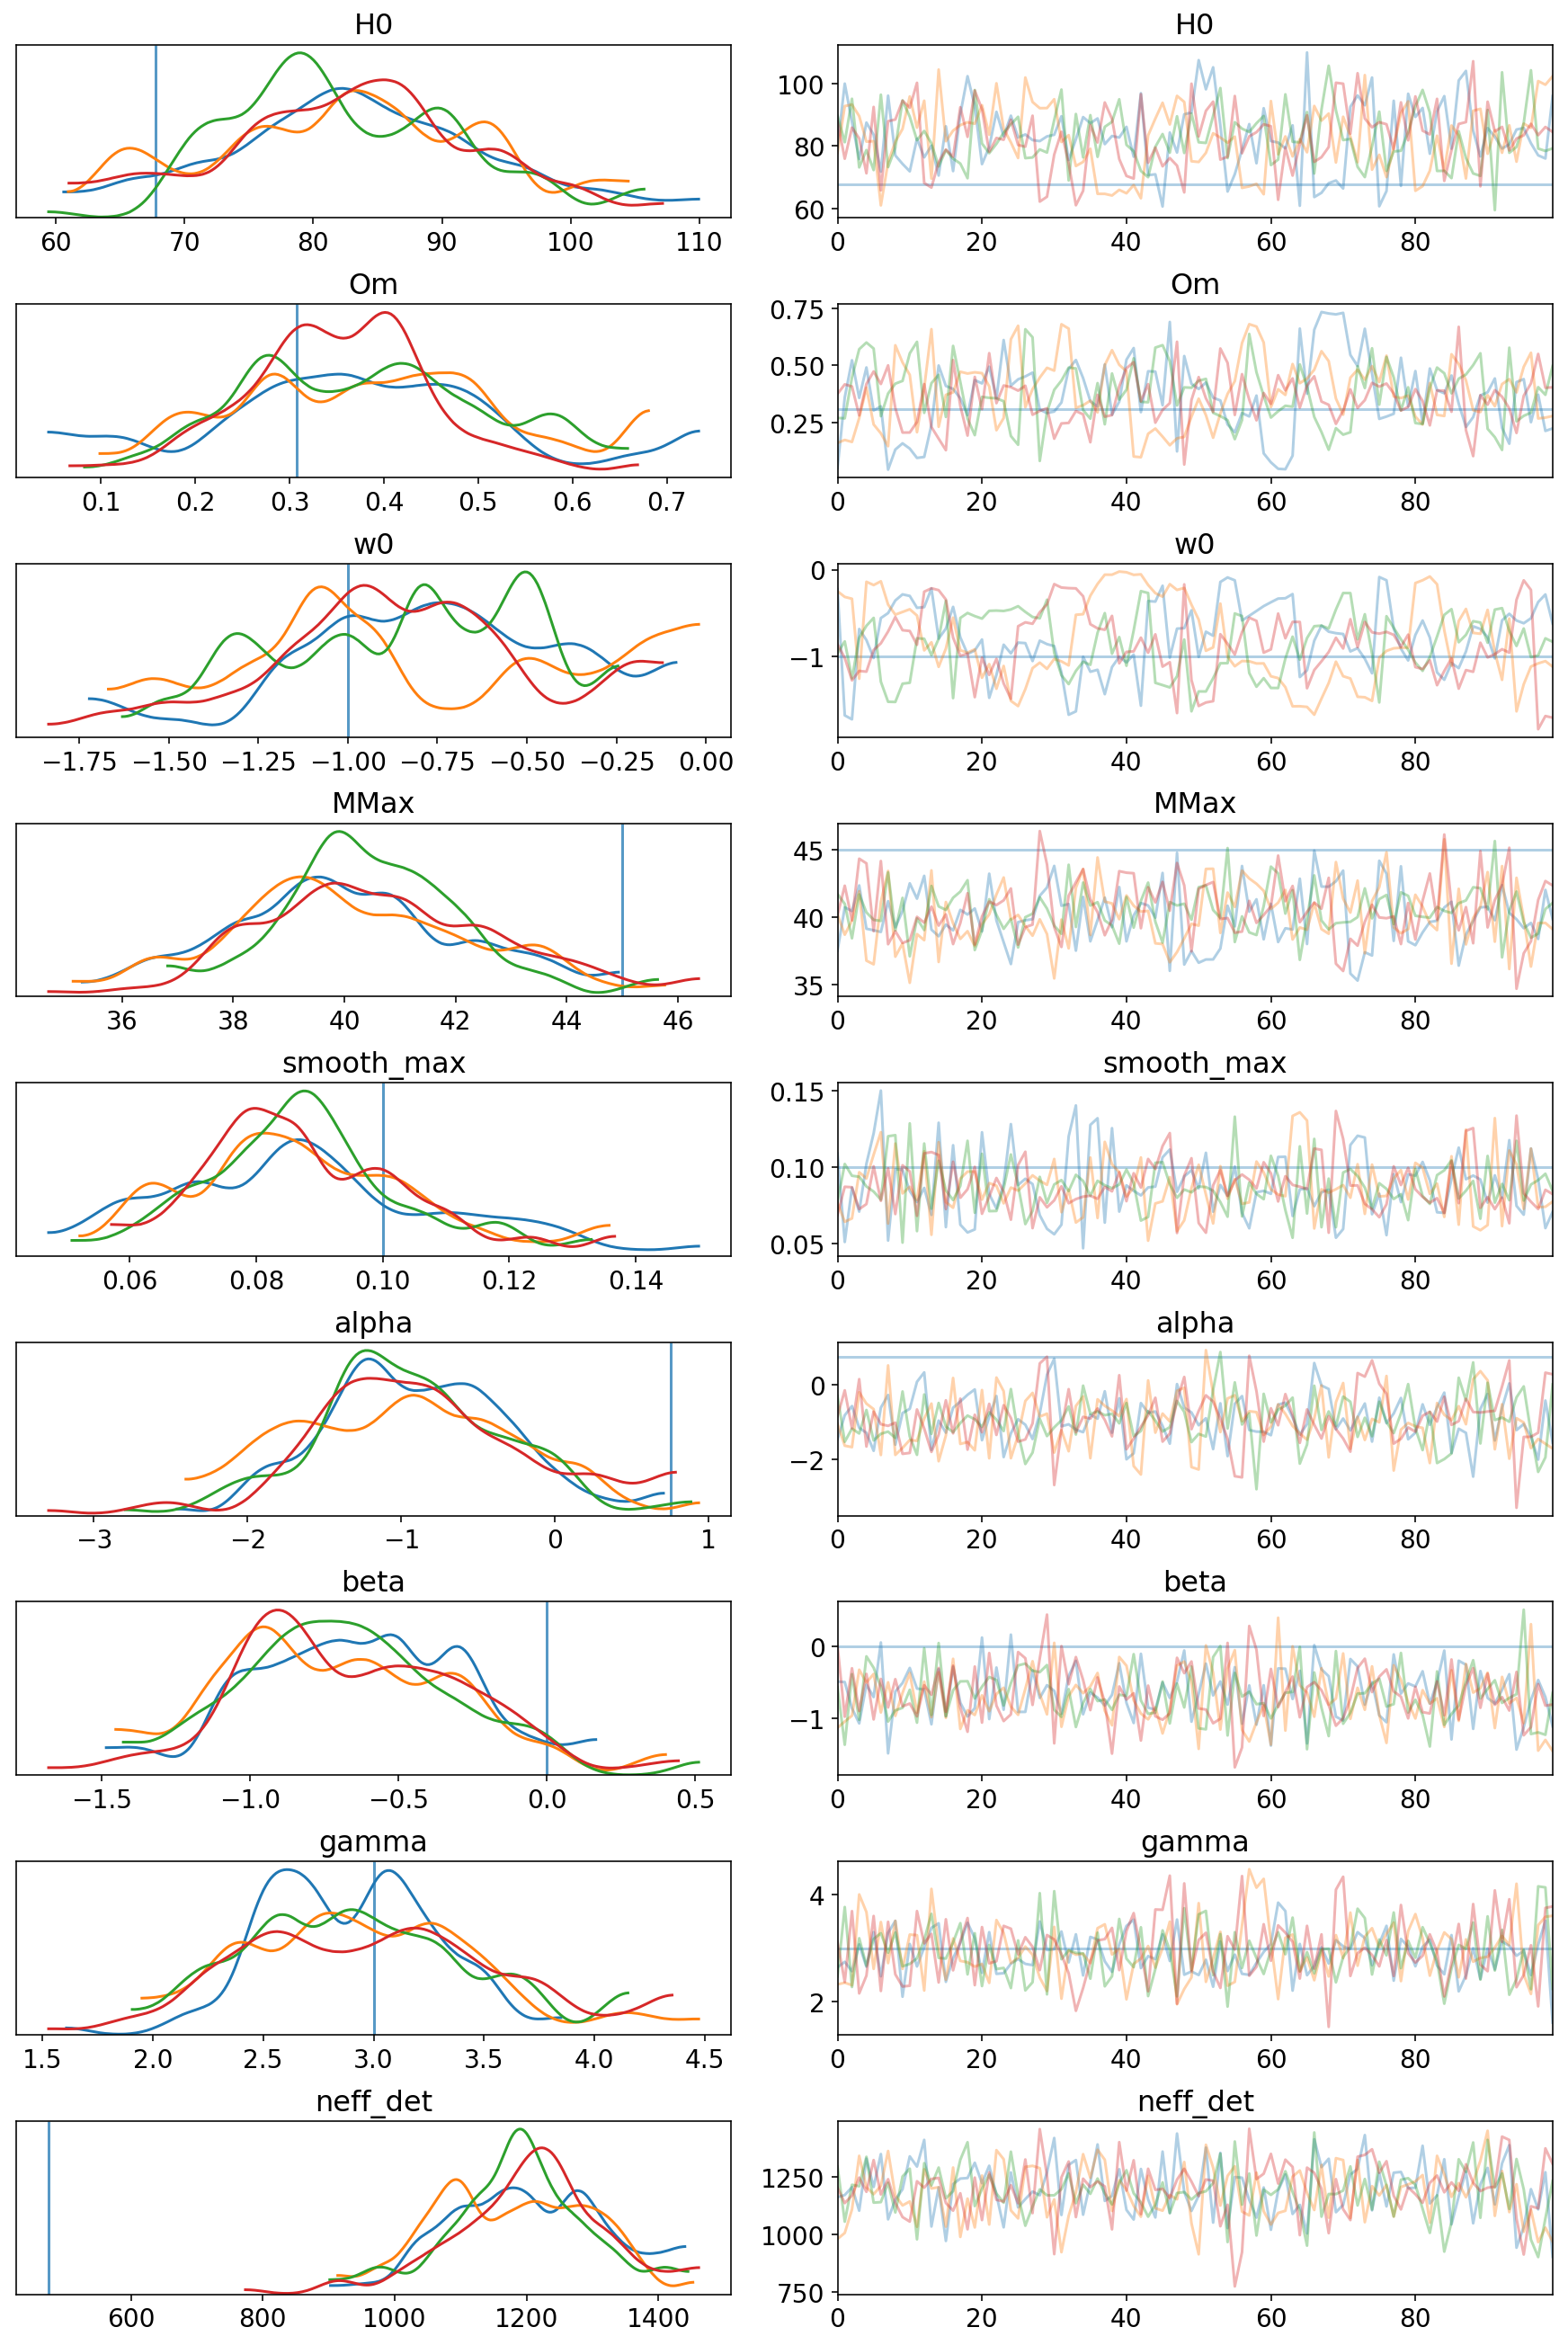

In [10]:
az.plot_trace(f, var_names=['H0', 'Om', 'w0', 'MMax', 'smooth_max', 'alpha', 'beta', 'gamma', 'neff_det'],
              lines=(('H0', {}, Planck15.H0.to(u.km/u.s/u.Mpc).value),
                     ('Om', {}, Planck15.Om0),
                     ('w0', {}, -1),
                     ('MMax', {}, true_params['MMax']),
                     ('smooth_max', {}, true_params['smooth_max']),
                     ('alpha', {}, true_params['alpha']),
                     ('beta', {}, true_params['beta']),
                     ('gamma', {}, true_params['gamma']),
                     ('neff_det', {}, 5*nobs))) # Ensure we are safe for selection effects